Lista 7 za tydzień.

Za tydzień zrozumienie co się odbywa w kodzie. Nie trzeba rozumieć rzeczy związanych z obrazkami.

klasyfikator, który będzie rozpoznawał symboli od 1 do 9. Moc bayesowskiego wnioskowania. Zdjęcia są sapisane tak, że każdy 
z pikseli ma swoją jasność. 

In [1]:
%matplotlib inline
import pyro
import torch
import numpy as np
import matplotlib.pyplot as plt
import pyro.optim as optim
import pyro.distributions as dist
from torch.distributions import constraints
from tqdm import tqdm
import seaborn as sns
from matplotlib import animation, rc
from IPython.display import HTML
import torch.nn as nn
from functools import partial
import pandas as pd
from pyro.contrib.autoguide import AutoDiagonalNormal
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, TracePredictive
from scipy.stats import norm
from scipy.stats import beta as betaP
import math

In [2]:
data = pd.read_csv('data.csv', sep=';')
data = data.drop(columns=",")

In [3]:
wroclaw_guitarist = data.city.value_counts()["WROCŁAW"]
wroclaw = int(wroclaw_guitarist/100)
non_wroclaw = int((data.city.size - wroclaw_guitarist)/100)

data_oz = torch.cat((torch.ones(wroclaw), torch.zeros(non_wroclaw)))
mean = torch.mean(data_oz)

In [4]:
data_oz

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.])

In [5]:
mean

tensor(0.3562)

In [7]:
def model(data):
    alpha0 = torch.tensor(20.0)
    beta0 = torch.tensor(30.0)
    guitarists = pyro.sample("guitarists", dist.Beta(alpha0, beta0))
    for i in pyro.plate("data_loop", len(data)):
        pyro.sample("obs_{}".format(i), dist.Bernoulli(guitarists), obs=data[i])


def guide(data):
    alpha = pyro.param("alpha", torch.tensor(15.0), constraint=constraints.positive)
    beta = pyro.param("beta", torch.tensor(20.0), constraint=constraints.positive)
    pyro.sample("guitarists", dist.Beta(alpha, beta))

In [8]:
adam_params = {"lr": 0.001}
optimizer = pyro.optim.Adam(adam_params)

svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

pyro.clear_param_store()

losses = []
means = []
for step in tqdm(range(5000)):
    losses.append(svi.step(data_oz))
    alpha = pyro.param("alpha").item()
    beta = pyro.param("beta").item()
    
    inferred_mean = alpha / (alpha + beta)
    factor = beta / (alpha * (1.0 + alpha + beta))
    inferred_std = inferred_mean * math.sqrt(factor)
    means.append(inferred_mean)
    svi.step(data_oz)

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [03:51<00:00, 21.63it/s]


In [9]:
Alpha = pyro.param("alpha").item()
Beta = pyro.param("beta").item()
Alpha, Beta

(21.349651336669922, 35.06480026245117)

In [10]:
inferred_mean = Alpha / (Alpha + Beta)
factor = Beta / (Alpha * (1.0 + Alpha + Beta))
inferred_std = inferred_mean * math.sqrt(factor)

print((inferred_mean, inferred_std))

(0.37844294735646317, 0.06400738681479072)


Text(0, 0.5, 'loss')

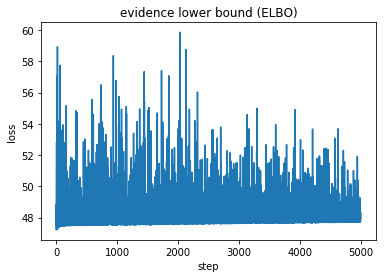

In [14]:
plt.plot(losses)
plt.title("evidence lower bound (ELBO)")
plt.xlabel("step")
plt.ylabel("loss")

Text(0, 0.5, 'mean')

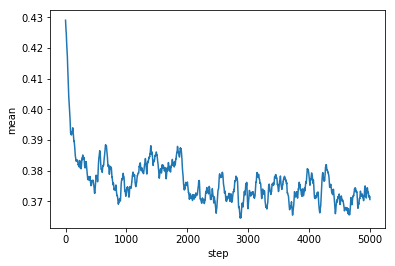

In [11]:
plt.plot(means)
plt.xlabel("step")
plt.ylabel("mean")

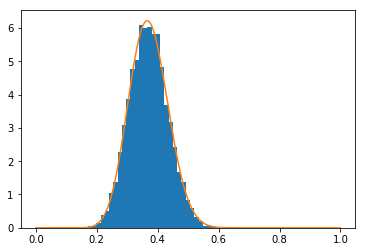

In [27]:
x = np.random.beta(Alpha, Beta, 10000)
plt.hist(x, density=True, bins=30)
x_axis = np.arange(0, 1, 0.001)
plt.plot(x_axis, betaP.pdf(x_axis, Alpha, Beta))

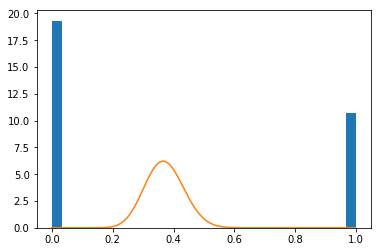

In [29]:
x = np.random.beta(Alpha, Beta, 10000)
plt.hist(data_oz, density=True, bins=30)
x_axis = np.arange(0, 1, 0.001)
plt.plot(x_axis, betaP.pdf(x_axis, Alpha, Beta))

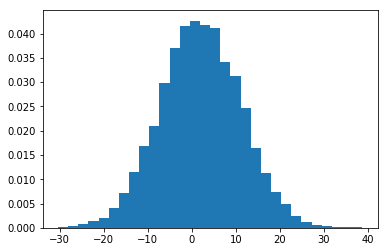

In [6]:
x = np.random.normal(2,9, 10000)
plt.hist(x, density=True, bins=30)
x_axis = np.arange(0, 1, 0.001)